# TODO: 
    incorporate 'quantum' effects of the system.
    test nonlinear effects by comparing to known calculations.

# First, let's compare the results from the linear and nonlinear time simulations given zero nonlinear coefficient.

Currently, Time_Sim_nonlin.py simulates a nonlinear system using purely classical dynamics. Quantum effects will be incorporated in future versions. This is done by using a non-Hermitian Hamiltonian approach. We simulate both quadrants, even though they will yield equivalent results. The derivation of the 'classical' equations of motion from the fully quantum open system model is describeds in detail in: http://aleph.physik.uni-kl.de/~korsch/papers/JPhysA_43_075306.pdf

More explicitly, we use the $-i*A$ as the equivalent linear non-Hermitian matrix for the $a$ quadrature c-number. We add the nonlinear interaction terms to this Hamiltonian. The non-Hermitian Hamiltonian equations of motion are

$$
\frac{d a}{dt}
= i \frac{\partial H}{\partial a^*} \hspace{1in}
\frac{d a^*}{dt}
=- i \frac{\partial H^*}{\partial a}.
$$

Notice we will NOT observe squeezing because the simulation is purely classical. The two quadrants are related by a complex conjugate. In future tests, we will compute the squeezing spectrum for examples in Milburn's book to see if they match our computer model.

## Testing

The simplest test is to compare to the linear system in the case when we set the nonlinear coefficient to zero. We do this below.

In [1]:
from sympy.physics.quantum import *
from sympy.physics.quantum.boson import *
from sympy.physics.quantum.operatorordering import *

In [2]:
import Roots
import Potapov
import Examples
import Time_Sims_nonlin
import functions
import tests
import pickle
import Hamiltonian

import numpy as np
import sympy as sp
import numpy.linalg as la
from scipy.integrate import ode

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## Make base system

Ex = Examples.Example3(r1 = 0.9, r3 = 0.9, max_linewidth=15.,max_freq=25.)
Ex.run_Potapov()
modes = functions.spatial_modes(Ex.roots,Ex.M1,Ex.E,Ex.delays)
M = len(Ex.roots)

A,B,C,D = Potapov.get_Potapov_ABCD(Ex.roots,Ex.vecs,Ex.T,z=0.)
A_d,C_d,D_d = map(Time_Sims_nonlin.double_up,(A,C,D))
B_d = -Time_Sims_nonlin.double_up(C.H)

In [4]:
## Make Hamiltonian and equations of motion

ham = Hamiltonian.Hamiltonian(Ex.roots,modes,Ex.delays)

ham.make_chi_nonlinearity(delay_indices=0,start_nonlin=0,
                           length_nonlin=0.1,indices_of_refraction=1.,
                           chi_order=3,chi_function=None,
                           )
H = ham.make_H(-1j*A)
eq_mot = ham.make_eq_motion()

a_in = lambda t: np.asmatrix([1.]*np.shape(D_d)[-1]).T  ## make a sample input function

f = Time_Sims_nonlin.make_f(eq_mot,B_d,a_in)
f_lin = Time_Sims_nonlin.make_f_lin(A_d,B_d,a_in)

Frequency is negative, taking absolute value.
Frequency is negative, taking absolute value.


In [5]:
y0 = np.asmatrix([0.]*10).T

In [6]:
Y_lin = Time_Sims_nonlin.run_ODE(f_lin, a_in, C_d, D_d, 2*M, T = 15, dt = 0.001)  ## select f here.

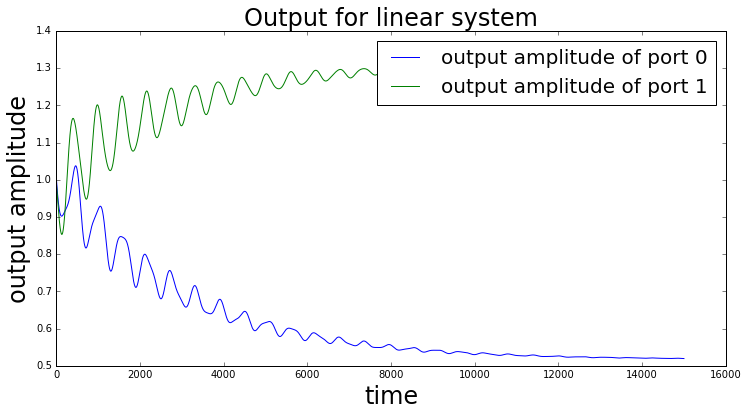

In [7]:
plt.figure(figsize=(12,6))
for i in range(2):
    plt.plot( [abs(y[i][0,0]) for y in Y_lin],label = 'output amplitude of port '+str(i))
    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output amplitude',{'fontsize': 24})
    plt.title('Output for linear system',{'fontsize': 24})
    plt.legend(loc='upper right',fontsize=20)

In [8]:
Y_nonlin = Time_Sims_nonlin.run_ODE(f, a_in, C_d, D_d, 2*M, T = 15, dt = 0.001)  ## select f here.

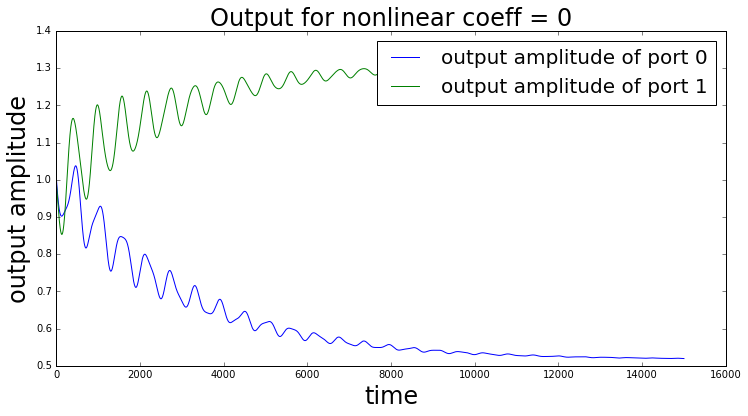

In [9]:
plt.figure(figsize=(12,6))
for i in range(2):
    plt.plot( [ abs(y[i][0,0]) for y in Y_nonlin],label = 'output amplitude of port '+str(i))
    plt.xlabel('time',{'fontsize': 24})
    plt.ylabel('output amplitude',{'fontsize': 24})
    plt.title('Output for nonlinear coeff = ' + str(0),{'fontsize': 24})
    plt.legend(loc='upper right',fontsize=20)

# Let's add nonlinear terms

We wish to see the effects of increasing the nonlinear term on the outputs.

In [100]:
#nonlin_coeffs = [10.0,32.5,55.0,77.5,100.0,200.0,500.0,1000.0,2000.0,5000.0,10000.0]

nonlin_coeffs = np.array(range(1,7))*1e24

save_outputs = True
run_again = True

In [101]:
def make_timeseries(coeff):
    ham.nonlin_coeff = coeff
    H = ham.make_H(-1j*A)
    eq_mot = ham.make_eq_motion()
    f = Time_Sims_nonlin.make_f(eq_mot,B_d,a_in)
    Y = Time_Sims_nonlin.run_ODE(f, a_in, C_d, D_d, 2*M, T = 15, dt = 0.001)  ## select f here.
    return Y

In [102]:
def run_over_again():
    for k in nonlin_coeffs:
        Y[k]=make_timeseries(k)

In [103]:
def save(Y):
    pkl_file = open('data/output_timeseries_various_nonlins.pkl', 'wb')
    pickle.dump(Y, pkl_file)
    pkl_file.close()

In [104]:
if run_again:
    Y = {} ##make dict to store timeseries
    run_over_again()
    if save_outputs:
        save(Y)

In [105]:
try:  # load file if it exisst
    pkl_file = open('data/output_timeseries_various_nonlins.pkl', 'rb')
    Y = pickle.load( open('data/output_timeseries_various_nonlins.pkl', 'rb'))
    pkl_file.close()
except: # otherwise, generate the data over again
    Y = {} ##make dict to store timeseries
    run_over_again()
    if save_outputs:
        save(Y)

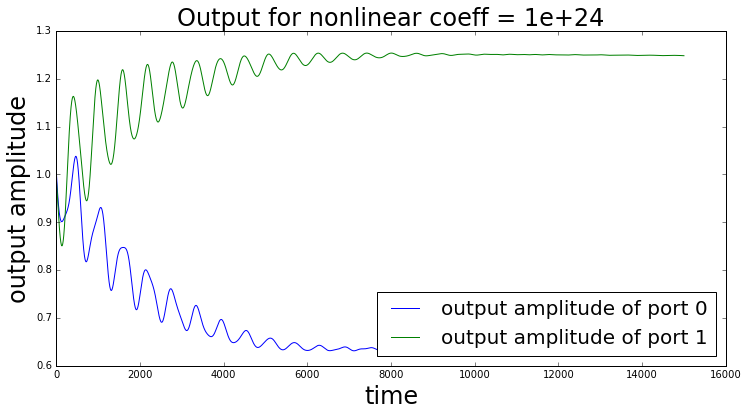

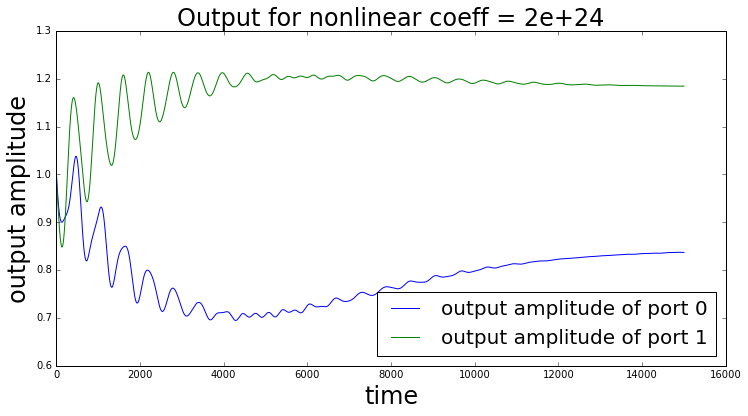

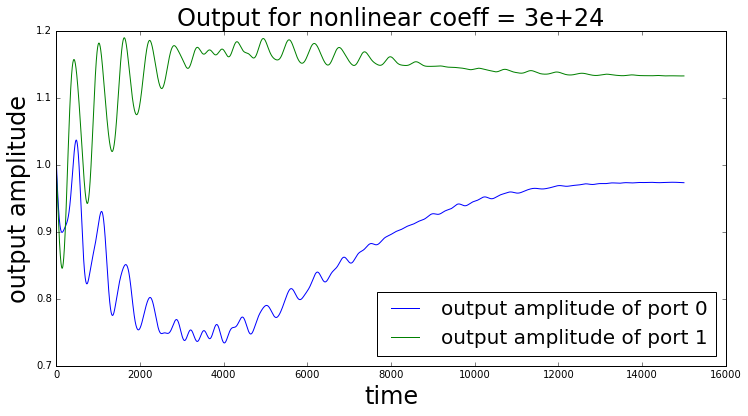

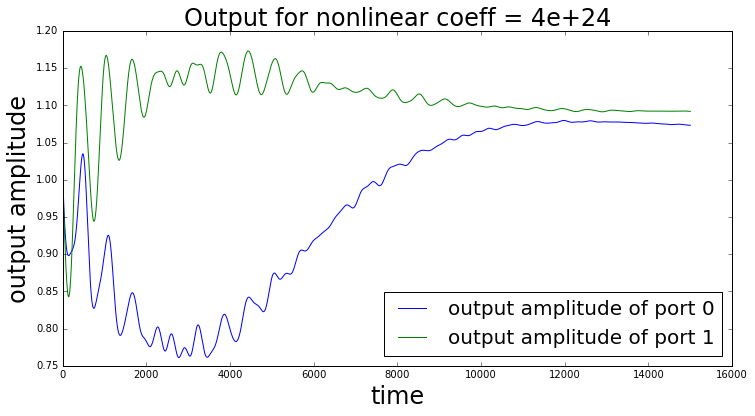

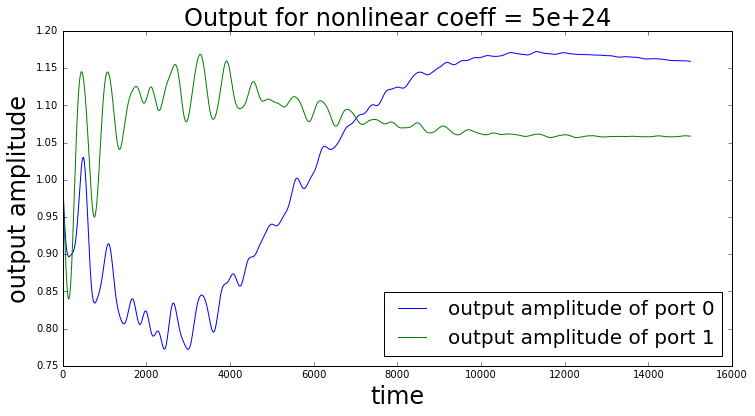

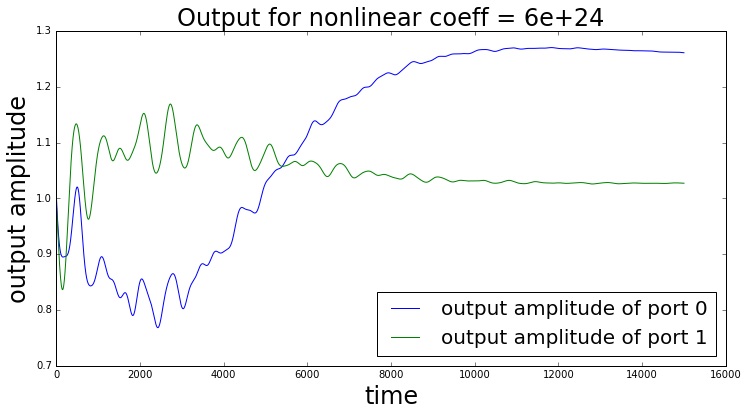

In [106]:
## plot timeseries for different nonlinearities
keys=Y.keys()

for k in sorted(keys):
    plt.figure(figsize=(12,6))
    for i in range(2):
        plt.xlabel('time',{'fontsize': 24})
        plt.ylabel('output amplitude',{'fontsize': 24})
        plt.title('Output for nonlinear coeff = ' + str(k),{'fontsize': 24})
        plt.plot( [ abs(y[i][0,0]) for y in Y[k]], label = 'output amplitude of port '+str(i))
        plt.legend(loc='lower right',fontsize=20)